In [1]:
library(tidyverse)
library(here)
library(furrr)
library(scales)
library(lemon)
suppressPackageStartupMessages(library(rtracklayer))
library(cowplot)

devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /mnt/expressions/mp/ychr
Loading required package: future

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor


Attaching package: ‘lemon’

The following object is masked from ‘package:purrr’:

    %||%


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading ychr


In [2]:
regions_cov <- function(arch) {
    df <- get_coverage(here("data/coord/capture_full.bed"),
                       here(paste0("data/bam/full_", arch, ".bam"))) %>% as.data.frame
    cutoff <- quantile(df$coverage, 0.975)
    
    arch <- case_when(
        arch == "den4" ~ "Denisova 4",
        arch == "den8" ~ "Denisova 8",
        arch == "spy1" ~ "Spy 1",
        arch == "mez2" ~ "Mezmaiskaya 2"
    )
    
    select(df, start, end, coverage) %>%
        filter(coverage <= cutoff) %>%
        group_by(start, end) %>%
        summarise(avg_cov = mean(coverage)) %>%
        mutate(name = arch)
}

In [3]:
den4 %<-% regions_cov("den4")
den8 %<-% regions_cov("den8")
spy1 %<-% regions_cov("spy1")
mez2 %<-% regions_cov("mez2")

In [8]:
ychr <- read_tsv(here("input/yregions.tsv"), col_names = c("start", "end", "class"), col_types = "iic")
ychr[ychr$class == "heterochromatic", ][3, "end"] <- 29.8e6
ychr <- filter(ychr, end < 30e6)

regions <- import.bed(here("data/coord/capture_full.bed")) %>% as.data.frame %>% select(start, end)

In [9]:
plot_cov <- function(df) {
    name <- unique(df$name)
    ggplot() +
        geom_rect(data = df, aes(xmin = start, xmax = end, ymin = 0, ymax = avg_cov)) +
        theme_classic() +
        theme(
            legend.position = "none",
            axis.title = element_blank(),
            axis.line = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank()
        ) +
        geom_segment(aes(x = 2.4e6, xend = 29.4e6, y = c(2, 10, 20), yend = c(2, 10, 20)), linetype = 2, size = 0.1) +
        geom_segment(aes(x = 2.4e6, xend = 29.4e6, y = 0, yend = 0), size = 0.1) +
        geom_text(aes(2.2e6, 8, label = name), hjust = "right") +
        xlim(x = c(0, 30e6)) + ylim(0, 25) +
        geom_text(aes(29.5e6, c(3, 11, 21), label = c("2X", "10X", "20X")), size = 3, hjust = "left")
}

In [10]:
p_den4 <- plot_cov(den4)
p_den8 <- plot_cov(den8)
p_spy1 <- plot_cov(spy1)
p_mez2 <- plot_cov(mez2)

p_regions <- ggplot(regions) +
    geom_rect(aes(xmin = start, xmax = end, ymin = 0, ymax = 1)) +
    theme_classic() +
    theme(
        legend.position = "none",
        axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()
    ) +
    xlim(x = c(0, 30e6)) + ggtitle("   ")

p_ychr <- ggplot(ychr) +
    geom_rect(aes(xmin = start, xmax = end, ymin = 0.2, ymax = 1, fill = class)) +
    theme_classic() +
    theme(
        legend.position = "bottom",
        axis.title = element_blank(),
        axis.line.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    ) +
    geom_segment(aes(y = 0.2, yend = 1, x = 40e3, xend = 40e3), size = 1/2) +
    geom_segment(aes(y = 0.2, yend = 0.2, x = 0, xend = 30e6), size = 1/2) +
    geom_segment(aes(y = 1, yend = 1, x = 0, xend = 30e6), size = 1/2) +
    ylim(0, 1) +
    scale_x_continuous(limits = c(0, 30e6), label = comma) +
    scale_fill_manual(values = c("#E69F00", "lightgray", "#009E73", "#0072B2", "#D55E00", "#CC79A7")) +
    coord_capped_cart(bottom = "both")

Warning message:
“Removed 3 rows containing missing values (geom_rect).”Warning message:
“Removed 3 rows containing missing values (geom_rect).”Warning message:
“Removed 3 rows containing missing values (geom_rect).”Warning message:
“Removed 3 rows containing missing values (geom_rect).”Warning message:
“Removed 3 rows containing missing values (geom_rect).”

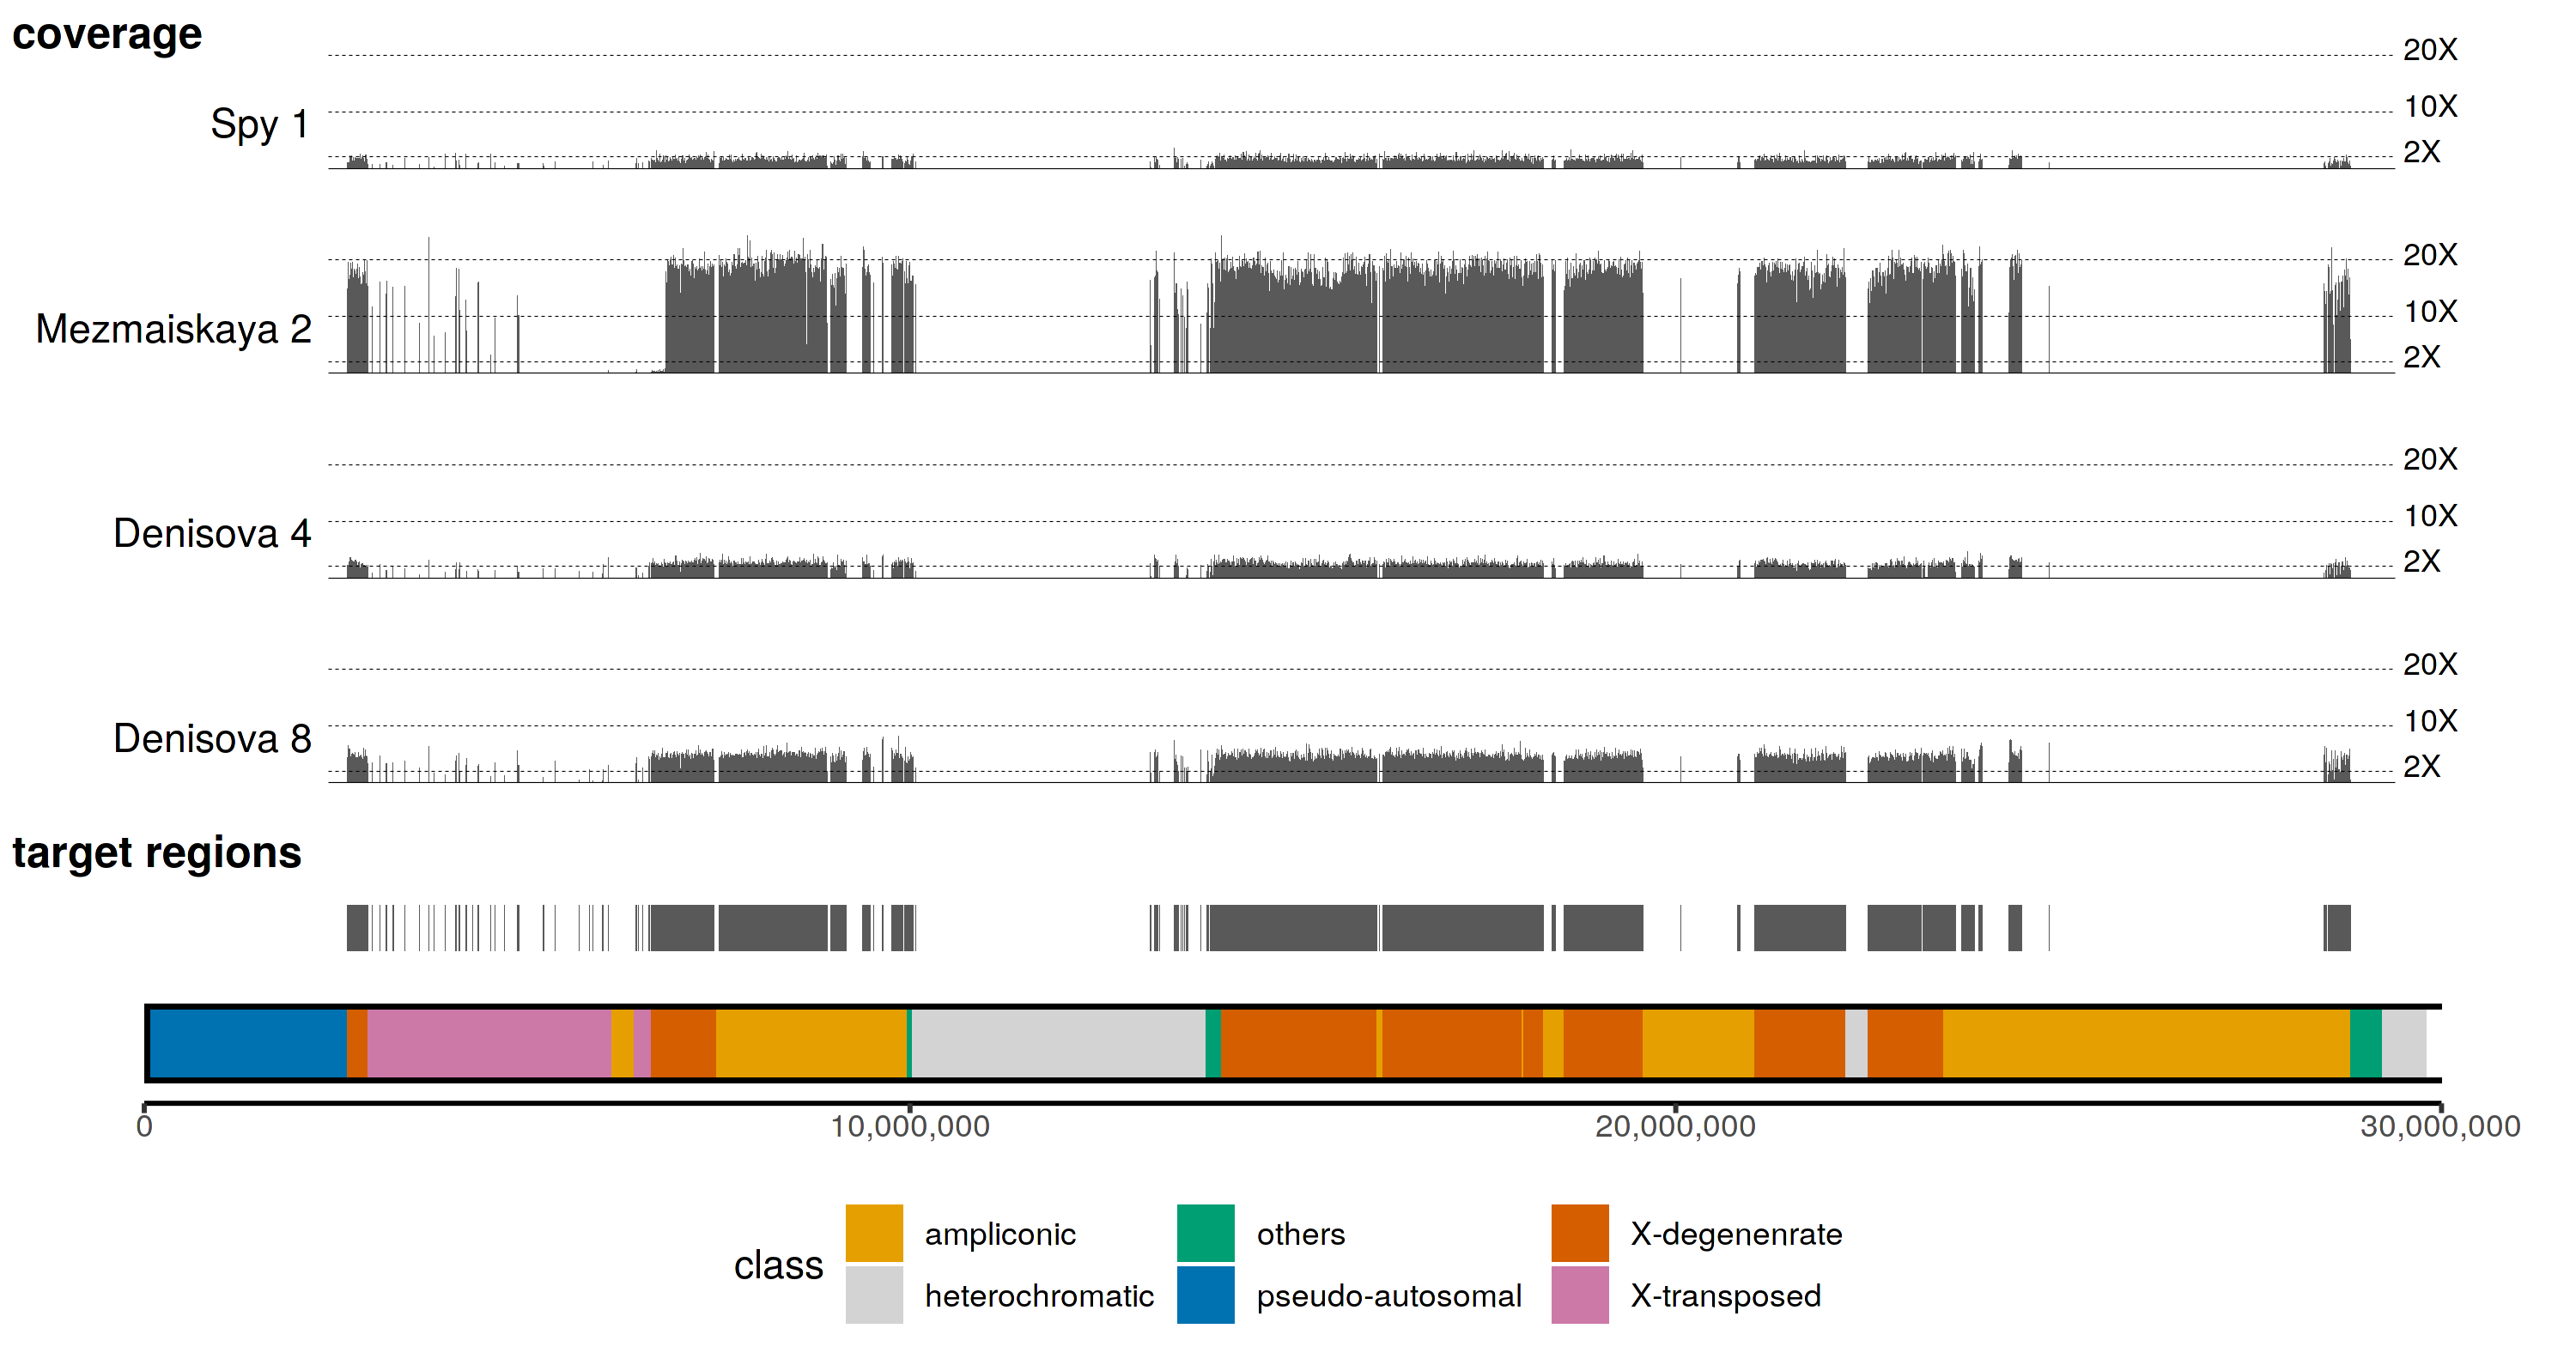

In [11]:
set_dim(10, 5.3)

plot_grid(p_spy1, p_mez2, p_den4, p_den8, p_regions, p_ychr, ncol = 1,
          labels = c(" coverage", "", "", "", " target regions", ""), hjust = "left", label_size = 12,
          rel_heights = c(0.15, 0.15, 0.15, 0.15, 0.12, 0.28))